In [67]:
import os
import pandas as pd
import numpy as np
from GoogleNews import GoogleNews
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from os import path
from nltk.corpus import stopwords
from textblob import TextBlob
import statsmodels.api as sm
from scipy import stats
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')
from scipy.stats import shapiro

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In order to extract articles I'm going to use a library called GoogleNews
https://pypi.org/project/GoogleNews/

license here:
https://github.com/Iceloof/GoogleNews/blob/master/LICENSE

In [68]:
dict_time = {'06/01/2020' : '12/31/2020',
             '06/01/2021' : '12/31/2021',
             '06/01/2022' : '12/31/2022',
             '06/01/2023' : '12/31/2023',
             '06/01/2019' : '12/31/2019',
             '06/01/2018' : '12/31/2018',
             '06/01/2017' : '12/31/2017',
             '06/01/2016' : '12/31/2016',
             '06/01/2015' : '12/31/2015',
             '06/01/2014' : '12/31/2014',
             '01/01/2020' : '06/01/2020',
             '01/01/2021' : '06/01/2021',
             '01/01/2022' : '06/01/2022',
             '01/01/2023' : '06/01/2023',
             '01/01/2019' : '06/01/2019',
             '01/01/2018' : '06/01/2018',
             '01/01/2017' : '06/01/2017',
             '01/01/2016' : '06/01/2016',
             '01/01/2015' : '06/01/2015',
             '01/01/2014' : '06/01/2014'}

def search_gn(s):
  df_final = pd.DataFrame()
  for x in dict_time:
    googlenews = GoogleNews(start=x,end=dict_time[x])
    googlenews.get_news(s)
    googlenews.enableException(True)
    result_FINAL = googlenews.result(sort=True)
    df_n = pd.DataFrame(result_FINAL)
    df_n['year'] = dict_time[x]
    df_n['year']= df_n['year'].str[-4:]
    df_final = df_final.append(df_n)
    
  return df_final

In [69]:
Ireland = search_gn('Housing Ireland') 
Uk = search_gn('Housing UK') 
USA = search_gn('Housing USA') 

In [70]:
Ireland = Ireland.drop_duplicates()
Uk = Uk.drop_duplicates()
USA = USA.drop_duplicates()

Ireland['Country'] = 'Eire'
Uk['Country'] = 'UK'
USA['Country'] = 'USA'

In [89]:
frames = [Ireland,USA,Uk]
Headlines = pd.concat(frames)
Headlines.info()

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [72]:
Headlines.head()

,title,desc,date,datetime,link,img,media,site,year,Country
0,Cabinet to discuss impact of housing Ukrainian...,None,1 hour ago,2023-05-03 22:54:13.338042,news.google.com/./articles/CBMiPmh0dHBzOi8vd3d...,https://lh3.googleusercontent.com/pZ5_jocQtI4K...,Irish Examiner,None,2020,Eire
1,Spending on housing 32.5% lower than planned f...,None,3 hours ago,2023-05-03 20:54:13.334046,news.google.com/./articles/CBMigAFodHRwczovL3d...,https://lh3.googleusercontent.com/SdqfETkyt1XH...,The Irish Times,None,2020,Eire
2,gov.ie - Castletown House to host Other Voices,None,9 hours ago,2023-05-03 14:54:13.346155,news.google.com/./articles/CBMiUGh0dHBzOi8vd3d...,https://encrypted-tbn0.gstatic.com/faviconV2?u...,Gov.ie,None,2020,Eire
3,Apprenticeships key to unlocking housing crisi...,None,9 hours ago,2023-05-03 14:54:13.338042,news.google.com/./articles/CBMid2h0dHBzOi8vbGF...,https://encrypted-tbn2.gstatic.com/faviconV2?u...,The Labour Party,None,2020,Eire
4,'I work very hard': Darragh O'Brien insists he...,None,9 hours ago,2023-05-03 14:54:13.337042,news.google.com/./articles/CBMiNWh0dHBzOi8vd3d...,https://lh3.googleusercontent.com/pZ5_jocQtI4K...,Irish Examiner,None,2020,Eire


In [73]:
headlines = Headlines[['title','media','year','Country']]
headlines.head()

,title,media,year,Country
0,Cabinet to discuss impact of housing Ukrainian...,Irish Examiner,2020,Eire
1,Spending on housing 32.5% lower than planned f...,The Irish Times,2020,Eire
2,gov.ie - Castletown House to host Other Voices,Gov.ie,2020,Eire
3,Apprenticeships key to unlocking housing crisi...,The Labour Party,2020,Eire
4,'I work very hard': Darragh O'Brien insists he...,Irish Examiner,2020,Eire


In [74]:
headlines.isna().sum()

title      0
media      0
year       0
Country    0
dtype: int64

Text(0.5, 1.0, 'Number of articles by newspaper')

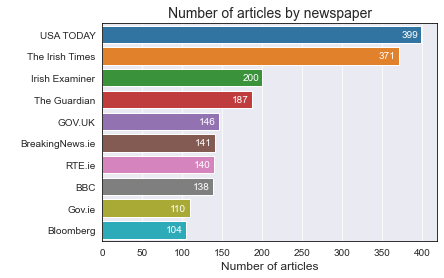

In [75]:
custom = {"axes.edgecolor": "black", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)
ax = sns.countplot(y=headlines["media"], order=headlines.media.value_counts().iloc[:10].index)
ax.bar_label(ax.containers[0], padding=-20, color='white', fontsize=10)
headlines["media"].unique()
ax.set_xlabel("Number of articles",fontsize=12)
ax.set_ylabel(" ")
ax.set_title("Number of articles by newspaper",fontsize=14)

In [76]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity  #there's also subjectivity if we want
    except:
        return None

headlines['polarity'] = headlines['title'].apply(sentiment_calc)

C:\Users\santi\AppData\Local\Temp/ipykernel_28808/3791301456.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headlines['polarity'] = headlines['title'].apply(sentiment_calc)


In [77]:
headlines.head()

,title,media,year,Country,polarity
0,Cabinet to discuss impact of housing Ukrainian...,Irish Examiner,2020,Eire,0.000000
1,Spending on housing 32.5% lower than planned f...,The Irish Times,2020,Eire,0.250000
2,gov.ie - Castletown House to host Other Voices,Gov.ie,2020,Eire,-0.125000
3,Apprenticeships key to unlocking housing crisi...,The Labour Party,2020,Eire,0.000000
4,'I work very hard': Darragh O'Brien insists he...,Irish Examiner,2020,Eire,-0.379167


<AxesSubplot:xlabel='Country', ylabel='polarity'>

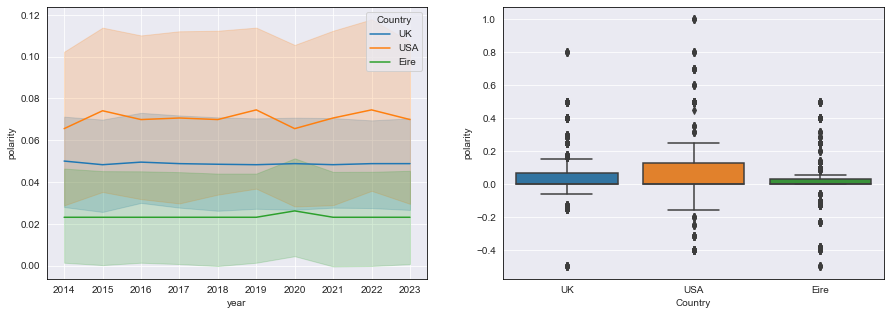

In [78]:
headlines = headlines.sort_values('year')
fig, ax = plt.subplots(1,2,figsize=(15, 5))
sns.lineplot(data = headlines,x='year',y='polarity',hue='Country',ax=ax[0])
sns.boxplot(y= 'polarity',data=headlines,x='Country',ax=ax[1])

p value 0.0
stat value 0.7312585115432739


c:\Users\santi\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


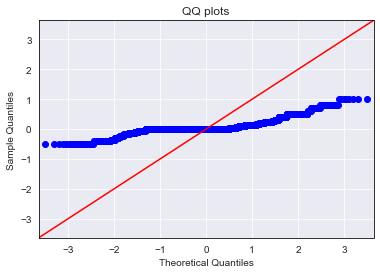

In [79]:
fig = sm.qqplot(headlines['polarity'], line='45')
plt.title('QQ plots')
stat, p = shapiro(headlines['polarity'])
print('p value ' + str(p))
print('stat value ' + str(stat))

In [80]:
a = headlines[headlines['Country']=='Eire']
b = headlines[headlines['Country']=='USA'] 
c = headlines[headlines['Country']=='UK']

stats.kruskal(a['polarity'],b['polarity'],c['polarity'])

KruskalResult(statistic=19.387967637719296, pvalue=6.165329894858369e-05)

In [81]:
import string
stopwords = set(stopwords.words("english"))
stopwords.add('housing')
stopwords.add('house')
stopwords.add('ireland')
stopwords.add('usa')
stopwords.add('uk')
stopwords.add('us')
stopwords.add(' ')
stopwords.add('')
stopwords.add('home')
stopwords.add('homes')
stopwords.add('irish')


In [82]:

def tk(x):
    text = x.str.cat(sep=' ')
    tokens = nltk.word_tokenize(text)
    tokens = [''.join(char for char in item if char not in string.punctuation) for item in tokens]
    tokens = [x.lower() for x in tokens]
    filtered_token = []
    for w in tokens:
        if w not in stopwords:
          filtered_token.append(w)
    return filtered_token

eire = tk(a['title'])
USA = tk(b['title'])
uk = tk(c['title'])


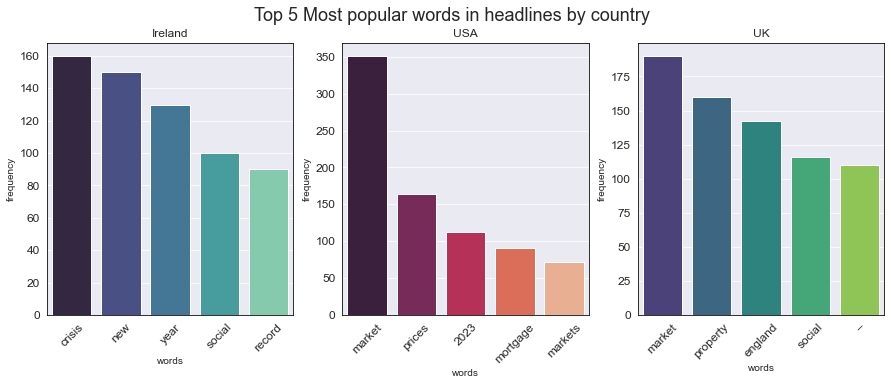

In [83]:
from collections import Counter
fig, ax = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle('Top 5 Most popular words in headlines by country',fontsize=18)
a = Counter(eire)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0 ,x='index',data=a.nlargest(5, 0), ax=ax[0], palette= 'mako')
ax[0].set_title('Ireland')
ax[0].set(xlabel='words', ylabel='frequency')
ax[0].tick_params(axis='x',labelrotation=45, labelsize=12)
ax[0].tick_params(labelsize=12)
a = Counter(USA)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0,x='index',data=a.nlargest(5, 0),ax=ax[1], palette= 'rocket')
ax[1].set_title('USA')
ax[1].set(xlabel='words', ylabel='frequency')
ax[1].tick_params(axis='x',labelrotation=45,labelsize=12)
ax[1].tick_params(labelsize=12)
a = Counter(uk)
a = pd.DataFrame.from_dict(a, orient='index').reset_index()
sns.barplot(y=0,x='index',data=a.nlargest(5, 0), ax=ax[2], palette= 'viridis')
ax[2].set_title('UK')
ax[2].set(xlabel='words', ylabel='frequency')
ax[2].tick_params(axis='x',labelrotation=45,labelsize=12)
ax[2].tick_params(labelsize=12)


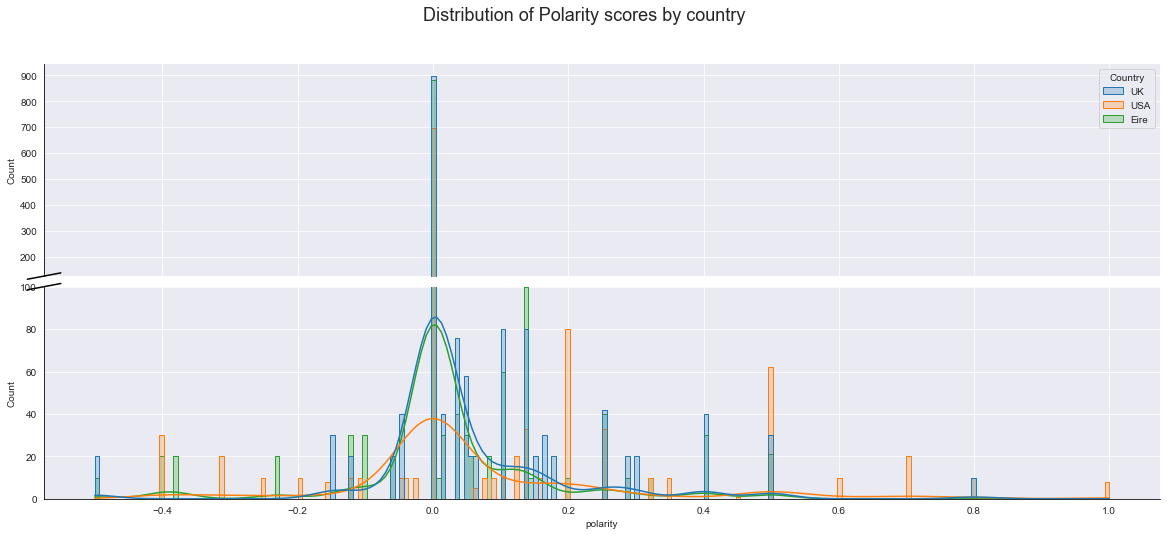

In [84]:
f, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'hspace':0.05},figsize=(20, 8))
f.suptitle('Distribution of Polarity scores by country',fontsize=18)
sns.histplot(x= 'polarity',data=headlines, hue='Country',kde=True , ax=ax_top, element="step")
sns.histplot(x= 'polarity',data=headlines, hue='Country',kde=True , ax=ax_bottom, element="step")
ax_top.set_ylim(bottom=125) 
ax_bottom.set_ylim(0,100)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
d = .015 
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs) 

ax_bottom.legend_.remove()
plt.show()

#### real sentiment analysis

In [123]:
headlines = Headlines[['title','media','Country','year']]
headlines.head()

,title,media,Country,year
0,Cabinet to discuss impact of housing Ukrainian...,Irish Examiner,Eire,2020
1,Spending on housing 32.5% lower than planned f...,The Irish Times,Eire,2020
2,gov.ie - Castletown House to host Other Voices,Gov.ie,Eire,2020
3,Apprenticeships key to unlocking housing crisi...,The Labour Party,Eire,2020
4,'I work very hard': Darragh O'Brien insists he...,Irish Examiner,Eire,2020


In [119]:
test = headlines[['title','year']]
test.head()

,title,year
0,Cabinet to discuss impact of housing Ukrainian...,2020
1,Spending on housing 32.5% lower than planned f...,2020
2,gov.ie - Castletown House to host Other Voices,2020
3,Apprenticeships key to unlocking housing crisi...,2020
4,'I work very hard': Darragh O'Brien insists he...,2020


In [125]:
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words("english"))
#do we need to delete names? no right?
from nltk.corpus import names
nltk.download('names')
all_names = set(names.words())
from nltk.stem import PorterStemmer
ps = PorterStemmer()

'''  AL POSTO DI STEMMER

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize(word)       '''

test['title_token'] = test['title'].apply(lambda row: [ps.stem(word.lower()) for word in nltk.word_tokenize(row) if word.lower() not in stop_words ])


[nltk_data] Downloading package names to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [128]:
test.head()

,title,year,title_token
0,Cabinet to discuss impact of housing Ukrainian...,2020,"[cabinet, discuss, impact, hous, ukrainian, up..."
1,Spending on housing 32.5% lower than planned f...,2020,"[spend, hous, 32.5, %, lower, plan, first, fou..."
2,gov.ie - Castletown House to host Other Voices,2020,"[gov.i, -, castletown, hous, host, voic]"
3,Apprenticeships key to unlocking housing crisi...,2020,"[apprenticeship, key, unlock, hous, crisi, sol..."
4,'I work very hard': Darragh O'Brien insists he...,2020,"[', work, hard, ', :, darragh, o'brien, insist..."


In [130]:
def is_letter_only(word):
    for char in word:
        if not char.isalpha():
            return False
    return True

In [131]:
data_cleaned = []

# Create a loop for all documents
for doc in test['title_token']:
    print(doc)
    doc_cleaned = ' '.join(word for word in doc.split() if is_letter_only(word))
    data_cleaned.append(doc_cleaned)


['cabinet', 'discuss', 'impact', 'hous', 'ukrainian', 'upcom', '...']


AttributeError: 'list' object has no attribute 'split'